# 🧠 Neural Network Model - Multi-class Classification

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid
import json

# Load Dataset

In [13]:
data = np.load("brain_mri_preprocessed.npz")

X = data["X_train"]
y = data["y_train"]

X_test = data["X_test"]
y_test = data["y_test"]

print("Train shape:", X.shape)
print("Test shape:", X_test.shape)

# ============================
# TRAIN / VALIDATION SPLIT
# ============================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# ============================
# NORMALIZATION
# ============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled mean:", X_train_scaled.mean())



Train shape: (5521, 16384)
Test shape: (1205, 16384)
Scaled mean: -1.2285437361467456e-14


# ⚙️ Define Neural Network Architecture

In [14]:
# ============================
# NETWORK SETTINGS
# ============================
input_size  = X_train_scaled.shape[1]
hidden_size = 64
output_size = 1

def sigmoid_grad(z):
    """Derivative of sigmoid using z, not a."""
    s = sigmoid(z)
    return s * (1 - s)


def rand_initialize_weights(L_in, L_out):
    """Xavier initialization."""
    eps = np.sqrt(6) / np.sqrt(L_in + L_out)
    return np.random.uniform(-eps, eps, size=(L_out, L_in + 1))


# 🧮 Forward Propagation + Cost Function

In [15]:
# ============================
# COST FUNCTION (corrected)
# ============================
def nn_cost_function(theta1, theta2, X, y, Lambda):
    m = X.shape[0]

    # Forward
    a1 = np.c_[np.ones((m, 1)), X]
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m, 1)), a2]
    z3 = a2 @ theta2.T
    h = sigmoid(z3)

    h = np.clip(h, 1e-10, 1 - 1e-10)

    J = (-1/m) * np.sum(
        y.reshape(-1, 1) * np.log(h) + (1 - y.reshape(-1, 1)) * np.log(1 - h)
    )

    # Regularization (no bias)
    reg = (Lambda/(2*m)) * (
        np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2)
    )

    return J + reg


# 🔁 Gradient Descent for Neural Network

In [16]:
def gradient_descent_nn(X, y, X_val, y_val, input_size, hidden_size, output_size,
                        alpha=0.5, iters=400, Lambda=0.1):

    m = X.shape[0]

    theta1 = rand_initialize_weights(input_size, hidden_size)
    theta2 = rand_initialize_weights(hidden_size, output_size)

    J_train = []
    J_val   = []

    for it in range(iters):

        # ---------- Forward ----------
        a1 = np.c_[np.ones((m, 1)), X]
        z2 = a1 @ theta1.T
        a2 = sigmoid(z2)
        a2_bias = np.c_[np.ones((m, 1)), a2]
        z3 = a2_bias @ theta2.T
        h = sigmoid(z3)

        # ---------- Backprop ----------
        d3 = h - y.reshape(-1, 1)
        d2 = (d3 @ theta2[:, 1:]) * sigmoid_grad(z2)

        Delta1 = d2.T @ a1
        Delta2 = d3.T @ a2_bias

        theta1_grad = (1/m) * Delta1
        theta2_grad = (1/m) * Delta2

        # Regularization
        theta1_grad[:, 1:] += (Lambda/m) * theta1[:, 1:]
        theta2_grad[:, 1:] += (Lambda/m) * theta2[:, 1:]

        # ---------- Update ----------
        theta1 -= alpha * theta1_grad
        theta2 -= alpha * theta2_grad

        # ---------- Track cost ----------
        J_train.append(nn_cost_function(theta1, theta2, X, y, Lambda))
        J_val.append(nn_cost_function(theta1, theta2, X_val, y_val, Lambda))

        if it % 50 == 0:
            print(f"Iter {it}/{iters} | Train Cost={J_train[-1]:.4f} | Val Cost={J_val[-1]:.4f}")

    return theta1, theta2, J_train, J_val



# 🚀 Train the Neural Network

Iter 0/400 | Train Cost=0.3052 | Val Cost=0.3378
Iter 50/400 | Train Cost=0.0463 | Val Cost=0.1277
Iter 100/400 | Train Cost=0.0249 | Val Cost=0.1253
Iter 150/400 | Train Cost=0.0159 | Val Cost=0.1279
Iter 200/400 | Train Cost=0.0112 | Val Cost=0.1318
Iter 250/400 | Train Cost=0.0085 | Val Cost=0.1357
Iter 300/400 | Train Cost=0.0068 | Val Cost=0.1393
Iter 350/400 | Train Cost=0.0058 | Val Cost=0.1425


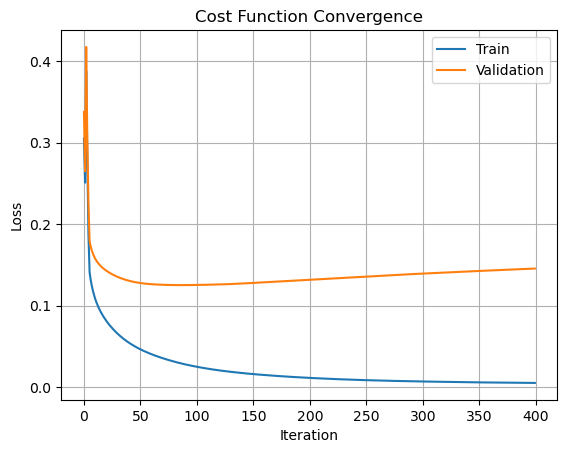

In [17]:
# ============================
# TRAIN NN
# ============================
theta1, theta2, J_train, J_val = gradient_descent_nn(
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    input_size, hidden_size, output_size,
    alpha=0.5, iters=400, Lambda=0.1
)


# ============================
# COST CURVES
# ============================
plt.plot(J_train, label="Train")
plt.plot(J_val, label="Validation")
plt.title("Cost Function Convergence")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 📈 Predictions and Evaluation

In [18]:
# ============================
# PREDICTION
# ============================
def predict(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.c_[np.ones((m,1)), X]
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m,1)), a2]
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return (h >= 0.5).astype(int).flatten()


y_pred = predict(X_test_scaled, theta1, theta2)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("TEST RESULTS:")
print(acc, prec, rec, f1)

TEST RESULTS:
0.9800829875518672 0.9988558352402745 0.9743303571428571 0.9864406779661017


# 📊 Confusion Matrix and Error Analysis

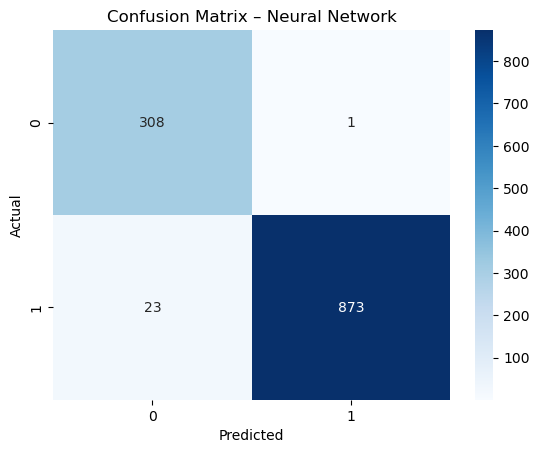

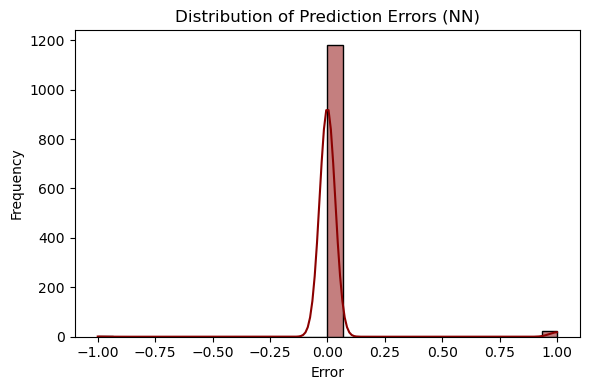

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Error distribution
errors = y_test - y_pred.flatten()
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True, color='darkred')
plt.title("Distribution of Prediction Errors (NN)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 📋 Model Summary

In [20]:
print(f"""
🧠 Neural Network Summary
--------------------------
Train Samples: {X_train.shape[0]}
Test Samples:  {X_test.shape[0]}
Features:      {X_train.shape[1]}
Hidden Units:  {hidden_layer_size}

Accuracy:  {acc:.4f}
Precision: {prec:.4f}
Recall:    {rec:.4f}
F1-score:  {f1:.4f}
""")


🧠 Neural Network Summary
--------------------------
Train Samples: 4692
Test Samples:  1205
Features:      16384
Hidden Units:  64

Accuracy:  0.9801
Precision: 0.9989
Recall:    0.9743
F1-score:  0.9864



# 💾 Save results for comparison

In [21]:
results = {
    "Model": "Neural Network",
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1": round(f1, 4)
}

with open("results_neural_network.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved Neural Network results to 'results_neural_network.json'")

✅ Saved Neural Network results to 'results_neural_network.json'
